<a href="https://colab.research.google.com/github/Yaninast/MachineLearning-/blob/master/News_Articles_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load required packages 

In [0]:
from google.colab import drive # mount Drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#from google.colab import auth
#auth.authenticate_user()
#print('Authenticated') - if yuo need to authenticate yourself 

%load_ext google.colab.data_table 
# used to display large pandas dataframes as an interactive data table. 

In [0]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 4.3MB/s 
     |████████████████████████████████| 552kB 20.0MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=9e178b15020314187b3e6a3b0054fbf9991c04adfdac5bcb4f2d42db79b10e64
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=f584690c42ecd4c3d2bf805c6e538daacc46962a8ec4ea5345daedff0c9f1b54
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [0]:
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,  WordNetLemmatizer


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import MDS
from sklearn.decomposition import PCA


from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

import pandas as pd
import os

from gensim.models import Word2Vec,LdaMulticore, TfidfModel, KeyedVectors
from gensim import corpora


from gensim.models.doc2vec import Doc2Vec, TaggedDocument


import numpy as np

import nltk
nltk.download('stopwords')
nltk.download('wordnet')


import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

   

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Function to process documents

The following data preprocessing steps are aimed to be applied to the corpus to reduce the noise in the data: tokenizing textual part, removing punctuations, and converting text from uppercase to lowercase. Non-standard word forms numbers, dates, acronyms, abbreviations etc. have been removed by excluding tokens longer than 4 symbols and numeric data. Moreover, some extremely common words, also called the stop words, are planned to be removed from the data since they are of little value in helping discriminate between documents. Lemmatization will be applied.

In [0]:
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    more_stop_words = ['february','therefore','cant','didnt','doesnt','dont','goes','isnt','hes',\
        'shes','thats','theres','theyre','wont','youll','youre','youve', 'br'\
        've', 're', 'vs', 'from', 'subject', 're', 'edu', 'use', 'percent', 'saturday', 'friday', 'monday','theyve','definetely','wednesday', 'thursday','perdue', 'three','whether', 'without'] 
    stop_words = set(stopwords.words('english') + more_stop_words)
    tokens = [w for w in tokens if not w in stop_words]         
    # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    
    # word lemmatizing # 
    lm = WordNetLemmatizer()
    tokens=[lm.lemmatize(word) for word in tokens]      
    return tokens

#Processing text into lists

In [0]:
#upload data
from google.colab import files 
uploaded = files.upload()


#read in corpus csv into python
data=pd.read_csv('2019_Summer_435_Class_Corpus.csv')
print(data.head())
print(data.describe())
data.columns
data.head()


Saving 2019_Summer_435_Class_Corpus.csv to 2019_Summer_435_Class_Corpus.csv
   Unnamed: 0  ...                                               Text
0           0  ...  President Donald Trump said Republicans "are t...
1           1  ...  President Trump is delaying immigration raids ...
2           2  ...  For the second time in a month, President Dona...
3           3  ...  As a top official in President Trump’s campaig...
4           4  ...  Senior administration officials told CNN that ...

[5 rows x 3 columns]
       Unnamed: 0
count   61.000000
mean    30.000000
std     17.752934
min      0.000000
25%     15.000000
50%     30.000000
75%     45.000000
max     60.000000


,Unnamed: 0,DSI_Title,Text
0,0,Shutdown-Unity.docx,"President Donald Trump said Republicans ""are t..."
1,1,YS_Doc1_Trump_ Immigration_policy.docx,President Trump is delaying immigration raids ...
2,2,Trump-Plans-to.docx,"For the second time in a month, President Dona..."
3,3,Manafort-Share-Russian.docx,As a top official in President Trump’s campaig...
4,4,Trump-says-DHS.docx,Senior administration officials told CNN that ...


In [0]:
#create empty list to store text documents titles
titles=[]

#for loop which appends the DSI title to the titles list
for i in range(0,len(data)):
    temp_text=data['DSI_Title'].iloc[i]
    titles.append(temp_text)

#create empty list to store text documents
text_body=[]

#for loop which appends the text to the text_body list
for i in range(0,len(data)):
    temp_text=data['Text'].iloc[i]
    text_body.append(temp_text)

#Note: the text_body is the unprocessed list of documents read directly form 
#the csv.
    
#empty list to store processed documents
processed_text=[]
#for loop to process the text to the processed_text list
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)

#Note: the processed_text is the PROCESSED list of documents read directly form 
#the csv.  Note the list of words is separated by commas.


#stitch back together individual words to reform body of text
final_processed_text=[]

for i in processed_text:
    temp_DSI=i[0]
    for k in range(1,len(i)):
        temp_DSI=temp_DSI+' '+i[k]
    final_processed_text.append(temp_DSI)
    
#Note: We stitched the processed text together so the TFIDF vectorizer can work.

#Sklearn TFIDF 

In [0]:
#the ngram_range will allow to include multiple words within the TFIDF matrix
#Given the size of the corpus, which is 61 documents, the min_df hyperparameter was set to 
#0.03 to filter terms that show up in at least 97% of corpus’ documents.

#Call Tfidf Vectorizer

Tfidf=TfidfVectorizer(ngram_range=(1,3), min_df = 0.03)
#fit the vectorizer using final processed documents.  

TFIDF_matrix=Tfidf.fit_transform(final_processed_text)  


#creating dataframe from TFIDF Matrix
matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)
matrix['trump']


Shutdown-Unity.docx                                                            0.220907
YS_Doc1_Trump_ Immigration_policy.docx                                         0.105934
Trump-Plans-to.docx                                                            0.219490
Manafort-Share-Russian.docx                                                    0.147687
Trump-says-DHS.docx                                                            0.115151
                                                                                 ...   
Will-Trump_Era.docx                                                            0.041635
why-no-obstruction-charge.docx                                                 0.145372
Veselnitskaya-Charged-Kremlin.docx                                             0.119879
YS_Doc2_Migrant_crisis .docx                                                   0.018333
JW_Doc1_Trump Says U.S. ‘Winning’ Trade War After Reviving China Talks.docx    0.172506
Name: trump, Length: 61, dtype: 

# Explore TFIDF Values

In [0]:
# calculate the average TFIDF score for every token
average_TFIDF={}
for i in matrix.columns:
    average_TFIDF[i]=np.mean(matrix[i])

average_TFIDF_DF=pd.DataFrame(average_TFIDF,index=[0]).transpose()

average_TFIDF_DF.columns=['TFIDF']
average_TFIDF_DF

,TFIDF
ability,0.003046
abroad,0.003035
abruptly,0.001944
absence,0.002145
absolute,0.001902
...,...
written,0.002953
wrote,0.006247
year,0.010935
year office,0.002976


In [0]:
#calculate Q1 and Q3 range
Q1=np.percentile(average_TFIDF_DF, 25)
Q3=np.percentile(average_TFIDF_DF, 75)
IQR = Q3 - Q1
outlier=Q3+(1.5*IQR)


#words that exceed the Q3+IQR*1.5
outlier_list=average_TFIDF_DF[average_TFIDF_DF['TFIDF']>=outlier]
print(outlier_list.sort_values(by = 'TFIDF', ascending = False))

average_TFIDF_DF.sort_values(by = 'TFIDF', ascending = False)
outlier_list_2=average_TFIDF_DF[average_TFIDF_DF['TFIDF']<=outlier]
print(outlier_list_2.sort_values(by = 'TFIDF', ascending = True))

#can export matrix to csv and explore further if necessary

                 TFIDF
trump         0.104520
border        0.063567
president     0.055144
shutdown      0.050755
government    0.045107
...                ...
reported      0.008213
build         0.008186
chuck         0.008182
presidential  0.008181
manafort      0.008140

[228 rows x 1 columns]
                        TFIDF
reviewing            0.001460
association          0.001506
ensuring             0.001506
appropriate          0.001519
involved underlying  0.001534
...                       ...
claim                0.008043
around               0.008074
director             0.008091
national security    0.008106
later                0.008127

[2243 rows x 1 columns]


In [0]:
# exctract the token with the maximum TFIDF score for every document 
#to see the most representative words for the documents 
max_doc_TFIDF={}
for row, value in matrix.iterrows():
  max_doc_TFIDF[row]= value.sort_values(ascending = False)

print(max_doc_TFIDF['YS_Doc1_Trump_ Immigration_policy.docx'][:15])
print(max_doc_TFIDF['YS_Doc2_Migrant_crisis .docx'][:20])

asylum            0.309588
planned           0.247670
immigration       0.247093
package           0.174673
illegally         0.157965
border            0.154680
change            0.151874
request           0.151334
pelosi            0.151334
migrant           0.145486
source            0.145486
family            0.140254
morgan            0.133359
alien             0.133359
around country    0.133359
Name: YS_Doc1_Trump_ Immigration_policy.docx, dtype: float64
migrant       0.453192
border        0.224855
shelter       0.207708
asylum        0.192875
maine         0.192875
condition     0.181370
family        0.145632
mexico        0.136231
crisis        0.132104
surge         0.128583
everything    0.128583
republic      0.128583
north         0.120913
option        0.120913
europe        0.114646
community     0.109348
south         0.109348
really        0.109348
supply        0.109348
texas         0.104758
Name: YS_Doc2_Migrant_crisis .docx, dtype: float64


In [0]:
# Moreover, the list of tokens that obtained higher than average TFIDF scores could be retrieved for any document

max_TFIDF_DF_doc_1=pd.DataFrame(max_doc_TFIDF['YS_Doc1_Trump_ Immigration_policy.docx'])

max_TFIDF_DF_doc_1.columns=['TFIDF']

max_TFIDF_DF_doc_2=pd.DataFrame(max_doc_TFIDF['YS_Doc2_Migrant_crisis .docx'])

max_TFIDF_DF_doc_2.columns=['TFIDF']

average_TFIDF_doc_1 = max_TFIDF_DF_doc_1.mean()
average_TFIDF_doc_2 = max_TFIDF_DF_doc_2.mean()

max_TFIDF_DF_doc_1[max_TFIDF_DF_doc_1['TFIDF']>0.04]


,TFIDF
asylum,0.309588
planned,0.247670
immigration,0.247093
package,0.174673
illegally,0.157965
...,...
million,0.042409
address,0.041182
party,0.041182
democratic,0.040040


In [0]:
# the most descriptive words of the corpus are obtained. It allows to have a approximate idea of the topics
# discussed within the corpus of documents  
max_TFIDF={}
for i in matrix.columns:
    max_TFIDF[i]=matrix[i].max()

max_TFIDF_DF=pd.DataFrame(max_TFIDF,index=[0]).transpose()

max_TFIDF_DF.columns=['TFIDF']

max_TFIDF_DF.sort_values(by=['TFIDF'],ascending = False)

,TFIDF
school,0.769770
nielsen,0.652327
morgan,0.614180
nuclear,0.498978
moore,0.488044
...,...
filed,0.048704
requirement,0.048671
robert,0.048444
president donald,0.046720


In [0]:
# Additionally, we could explore how documents would group by 'strong' tokens. Again, it might give the idea 
# how the documents would cluster 

matrix[['asylum']].sort_values(by=['asylum'], axis =0, ascending = False)

,asylum
YS_Doc1_Trump_ Immigration_policy.docx,0.309588
YS_Doc2_Migrant_crisis .docx,0.192875
Trump-says-DHS.docx,0.100957
JL_Trump Administration Calls for Medicaid Overhaul Home Health Care News.docx,0.000000
Fed-Interest-Rates.docx,0.000000
...,...
"JW_Doc2_ US- China trade agreement still ‘very much in the air’ despite Trump, Xi meeting, Chinese state media says.docx",0.000000
Obama_Border_Patrol_chief_to_Trump.docx,0.000000
Manufacturing-Jobs.docx,0.000000
A Republican senator close to President Donald Trump on Sunday backed a temporary re.docx,0.000000


# K Means Clustering - TFIDF



## Silhoette analysis 
The following section runs applies the k-means algorithm on the TFIDF matrix but first find the most optimal value using silhouette analysis.
For more information on the silhoutte analysis refer to https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

For n_clusters = 2 The average silhouette_score is : 0.369535295779584
For n_clusters = 3 The average silhouette_score is : 0.40268297223516997
For n_clusters = 4 The average silhouette_score is : 0.40378515960325617
For n_clusters = 5 The average silhouette_score is : 0.38708515826621476
For n_clusters = 6 The average silhouette_score is : 0.3798232264235442
For n_clusters = 7 The average silhouette_score is : 0.3567798203799205
For n_clusters = 8 The average silhouette_score is : 0.36181149916487626
For n_clusters = 9 The average silhouette_score is : 0.3500678996015364
For n_clusters = 10 The average silhouette_score is : 0.3546364681870827


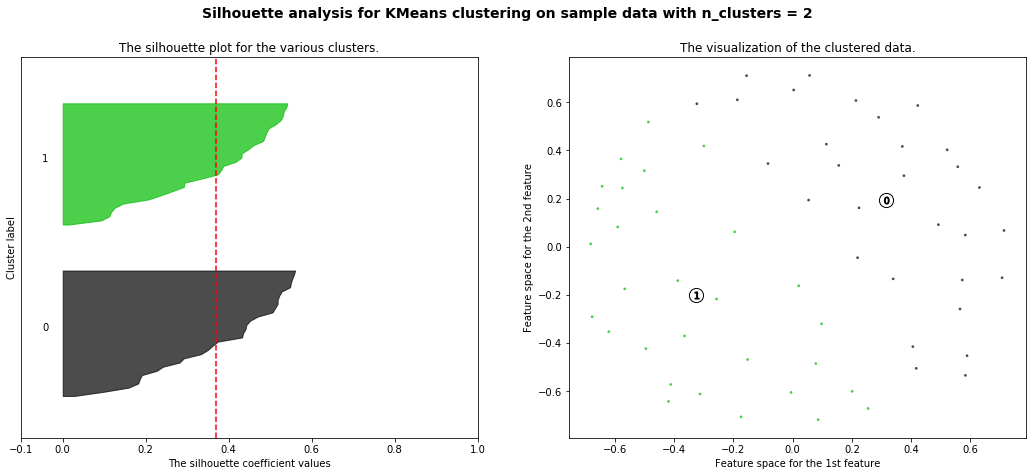

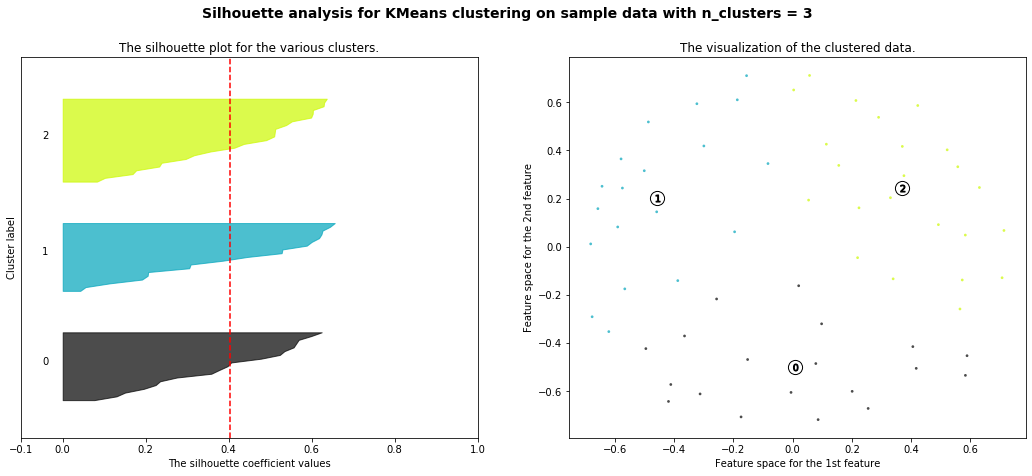

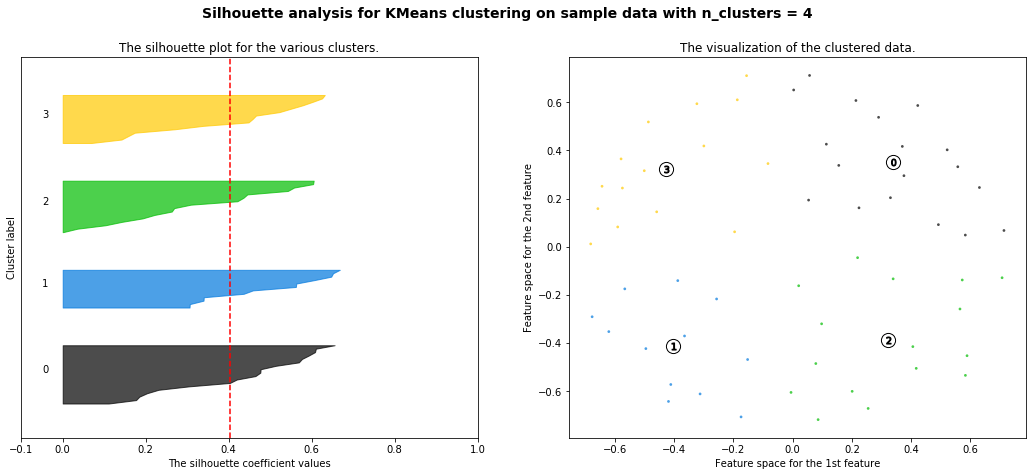

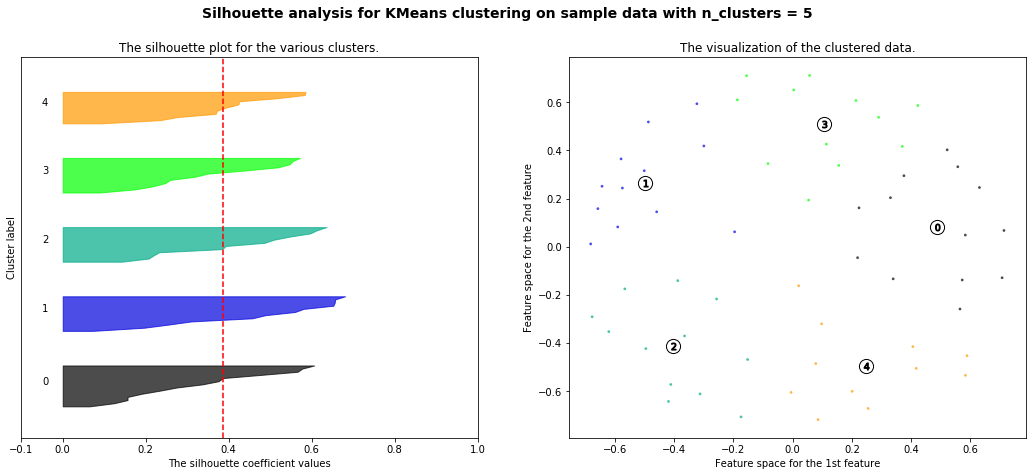

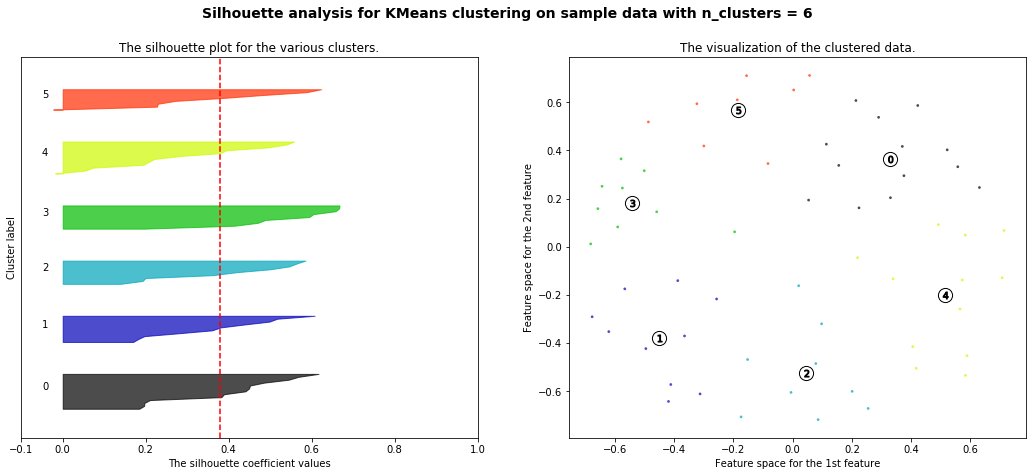

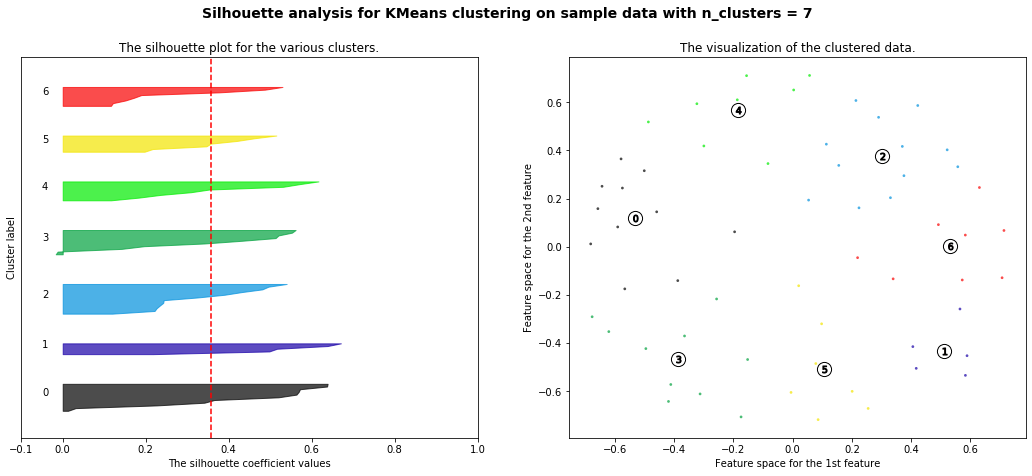

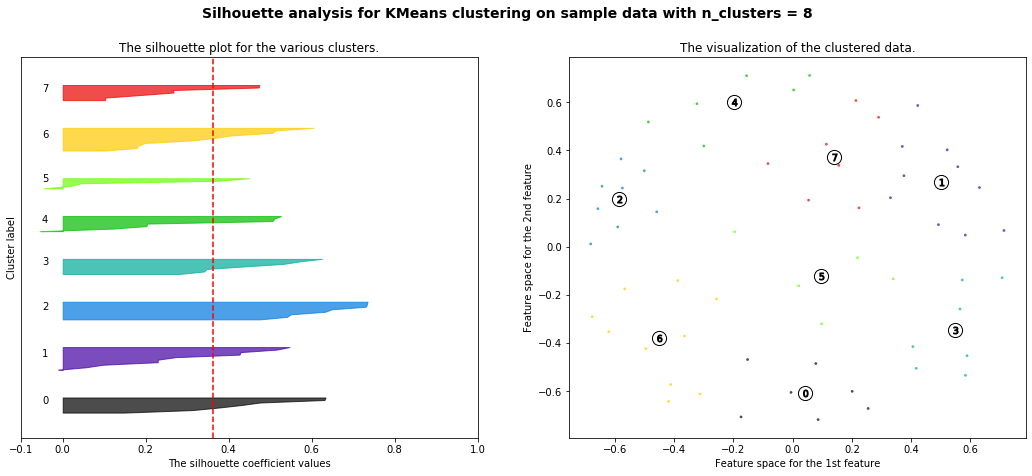

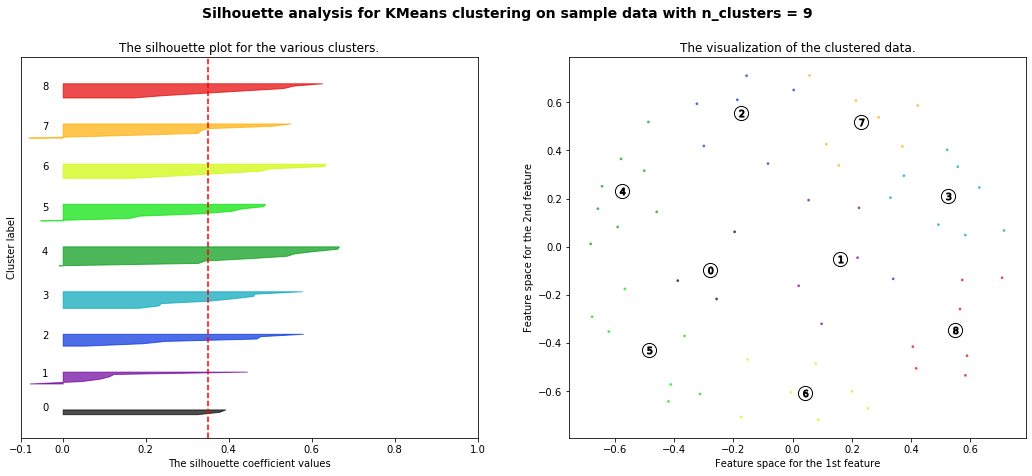

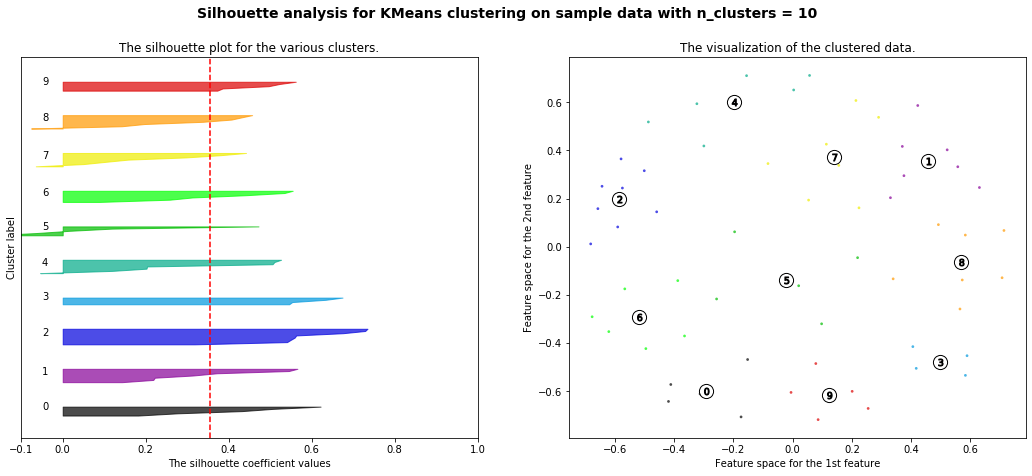

In [0]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=10)
dist = 1 - cosine_similarity(TFIDF_matrix)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


range_n_clusters = list(range(2,11))

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(pos) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(pos)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(pos, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(pos, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(pos[:, 0], pos[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## K-means clutering results
The results of the silhouette analysis suggest that k greater than 7 might not produce good clusters, and 5,6 or 7 might be the most optimal value for k. The  examination of the signal words for 5,6 and 7 clusterings indicates that 6 – means clustering algorithm produces slightly more meaningful and segregated clusters, and therefore has been used to extract topics within the present data and utilized for the further analysis. 
Consequently, the following tentative topics have been compiled based on the keywords:

0.   Trump’s immigration policy
1.   The US government shutdown
2.   US-China-trade
3.   Foreign affairs – NATO
4.   Social programs
5.   Russia election interference– Obstruction




In [0]:
k=6
km = KMeans(n_clusters=k, random_state =89)
km.fit(TFIDF_matrix)
clusters = km.labels_.tolist()


terms = Tfidf.get_feature_names()
Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]


#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

#dictionary to store terms and titles
cluster_terms={}
cluster_title={}


for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms
    
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
    cluster_title[i]=temp_titles

Top terms per cluster:
Cluster 0:
 border
 immigration
 immigrant
 trump
 migrant
 child
 family
 president
 morgan
 nielsen
 democrat
 asylum
 southern border
 address
 crisis
 southern
 illegal
 security
 government
 source
Cluster 0 titles: YS_Doc1_Trump_ Immigration_policy.docx, Trump-says-DHS.docx, Trump-Puerto-Rico.docx, Totally-bonkers-Trump.docx, Obama_Border_Patrol_chief_to_Trump.docx, Trump-Pushes-Wall.docx, It-May-Take .docx, The Real Problem with Immigration.docx, Trump Approval Rating Down Slips With Base.docx, Elusive Wall-for-DACA Deal Could Be Key to Ending Government Shutdown.docx, How Immigration Became So Controversial.docx, Trumps-Oval-Office.docx, YS_Doc2_Migrant_crisis .docx,Cluster 1:
 border
 trump
 shutdown
 government
 democrat
 house
 emergency
 president
 security
 federal
 pelosi
 schumer
 worker
 senate
 meeting
 republican
 border security
 would
 congress
 funding
Cluster 1 titles: Shutdown-Unity.docx, Shutdown2.docx, Trumps_ever-shifting_shutdown_Blame_

## Plotting k-means results 


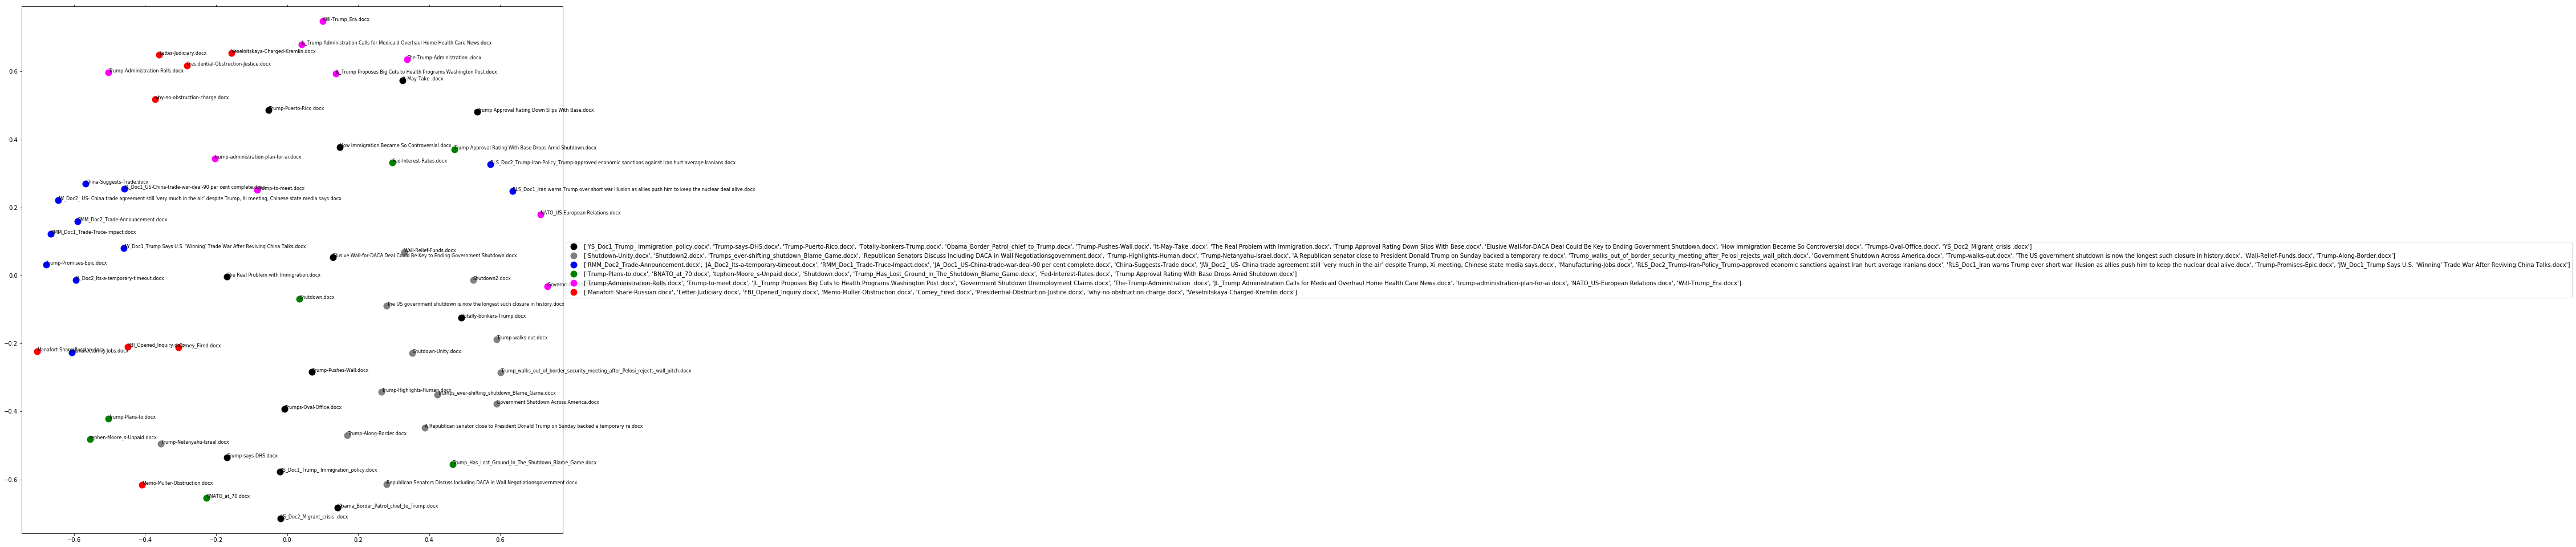

In [0]:
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.

%matplotlib inline 
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(TFIDF_matrix)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'green', 4: 'magenta', 
                  5:'red', 6:'orange', 7:'yellow'}


#set up cluster names using a dict.  
cluster_dict=cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(17, 17)) # set size
ax.margins(0.03) # Optional, just adds 3% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  


# Gensim Word2vec
There are opportunities to use the word2vec matrix to determine words which are similar.  Similar words can be used to create equivalent classes. Combining the terms that refer to the same concepts are useful from two perspectives, first it boosts the TFIDF scores of the important terms, and second it gives a chance for other representative terms to reveal themselves. Moreover, it was beneficial to substitute important two – grams with one gram equivalent to prevent the algorithm from parsing the two piece tokens in random ways and score each piece differently, thus creating a lot of noise in the data. 
So, in this section, two data frames have been created containing all similar words for each token in the vocabulary which are used to retrieve equivalent classes. 

In [0]:
# to create equivalent classes we could use Word2Vec trained on part of Google News dataset (about 100 billion words) 
# which has a good general understanding of the language and news vocabulary

import gensim
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
model = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

from sklearn.manifold import TSNE 

#join all processed DSI words into single list
processed_text_w2v=[]
for i in processed_text:
    for k in i:
        processed_text_w2v.append(k)

#obtain all the unique words from DSI
w2v_words=list(set(processed_text_w2v))


outside_words = set() # Unfortunately, the model is unable to infer vectors for unfamiliar words.
#This is one limitation of Word2Vec but  this  limitation does not really matter to me but I still want to
#keep track of the words not iincluded in the EC analysis. 

#empty dictionary to store words with vectors
w2v_vectors={}

#for loop to obtain pre-trained vectors 

for word in w2v_words:
  if word not in model.vocab:
    outside_words.add(word)
    continue
  temp_vec=model.word_vec(word)
  w2v_vectors[word]=temp_vec


#create a final dataframe to view word vectors
w2v_df=pd.DataFrame(w2v_vectors).transpose()

# reduce the dimensionality of the data to visualize the similarity between words 
# used t-SNE becuas it reduces dimensional space keeping relative pairwise distance between points.
# In other words, the algorithm maps multi-dimensional data to two or more dimensions, where points which were 
#initially far from each other are also located far away, and close points are also converted to close ones. 

twodim = TSNE(perplexity=5, n_components=2, init='pca', n_iter=3500, random_state=32).fit_transform(w2v_df)

tsne_df = pd.DataFrame(twodim, index=w2v_df.index, columns=['x', 'y'])

fig = plt.figure(figsize=(50,50))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_df['x'], tsne_df['y'])

for word, pos in tsne_df.iterrows():
    ax.annotate(word, pos)
plt.show()


#Since it is not an easy-to-read t-SNE plot we could create a dataframe 
# of the most similar words using Word2Vec embeddings 
i=1
similar_pairs={}
for row in tsne_df.itertuples():
  temp_list=[]
  for i in range(1,len(tsne_df)):
    if np.sqrt((row.x - tsne_df['x'][i])**2 + (row.y - tsne_df['y'][i])**2)<=5:
      if row.Index==tsne_df.index[i]:
        continue
      temp_list.append(tsne_df.index[i])
    similar_pairs[row.Index]=temp_list 

similarity_df= pd.DataFrame(similar_pairs.items(),columns=['Word', 'Similar Words'])
similarity_df.set_index('Word', inplace=True)
similarity_df


,Similar Words
Word,
relaxed,"{comfortable, uncomfortable}"
represents,"{represent, representing, comprised}"
entrepreneurial,"{enterprise, clientele, customer, commerce, co..."
impact,"{influence, affect, effect}"
prescription,"{drug, followup, heroin}"
...,...
sachs,"{coulter, cheerleader, obliteration, dreamer, ..."
consult,"{canvassed, consulted}"
alignment,{aligned}


In [0]:
import multiprocessing
# pretrained Word2Vec performs well but still does not seem to pick up all nuances of our data such as 
# identifying trump and president as close in meaning words or equivalent classes. Thus we could train our own 
# Word2Vec model

#word to vec
model_w2v = Word2Vec(processed_text, size=300, window=5, min_count=1, workers=multiprocessing.cpu_count(), iter =1000) 
# word2vec expects a sequence of sentences or documents as its input
# so we want t0 train word2vec on 61 documents 
#min_count - ignores all words with total frequency lower than 1.
                      
    #To save a model:
#model_w2v.save("word2vec.model")

    # To load a saved model:
    
#model_w2v = gensim.models.Word2Vec.load("word2vec.model")


#empty dictionary to store words with vectors
w2v_vectors_2={}

#for loop to obtain weights for each word
for i in w2v_words:
    temp_vec=model_w2v.wv[i]
    w2v_vectors_2[i]=temp_vec

#create a final dataframe to view word vectors
w2v_df_2=pd.DataFrame(w2v_vectors_2).transpose()

embedding_clusters = []
word_clusters = []
for word in w2v_words:
    embeddings = []
    words = []
    for similar_word, _ in model_w2v.most_similar(word, topn=4):
        words.append(similar_word)
        embeddings.append(model_w2v[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

similarity_df_2= pd.DataFrame(word_clusters,index =w2v_words,columns=['w1','w2','w3','w4'])
similarity_df_2

# Also we can plot the similarity of the words by reducing the dimensionality of the data using TSNE and
# in order to reduce plot overload label only 1000 data points at once


twodim_2 = TSNE(perplexity=5, n_components=2, init='pca', n_iter=3500, random_state=32).fit_transform(w2v_df_2)

tsne_df_2 = pd.DataFrame(twodim_2, index=w2v_df_2.index, columns=['x', 'y'])

def plot_with_matplotlib(x_vals, y_vals, labels):   

    plt.figure(figsize=(50, 50))
    plt.scatter(x_vals, y_vals)

    #
    # Label first 1000 data points
    #
    indices = list(range(len(labels)))
    selected_indices = indices[0:1000]
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

plot_with_matplotlib(tsne_df_2['x'], tsne_df_2['y'], tsne_df_2.index)

,w1,w2,w3,w4
relaxed,overruled,recorded,anymore,find
represents,surrounding,union,whose,detail
entrepreneurial,model,dynamic,population,nationalism
impact,characterized,offset,wavering,divided
prescription,bouncing,ruining,price,rising
...,...,...,...,...
sachs,goldman,hawk,lighthizer,investment
consult,eightythree,voter,reutersipsosalso,blamegame
alignment,detailed,bloomberg,hike,engineering
deferred,childhood,protecting,arrival,codify


# EC clean up 


Another approach to building equivalent classes which is more comprehensive but human labor intensive is to create the corpus ontology. The ontology is a guide to the corpus of the documents and used to inspect the structure and connections between documents within the corpus. The ontology sheds light on what might cause the clusters to form not as expected and facilitates the discovery of the implicit concepts within the corpus. Thus, it helps to identify possible ways to tighten up the clusters.
Below are the links to my ontology on the Trump administration corpus. 

*   Page 1. https://www.lucidchart.com/documents/embeddedchart/c6ab2acb-adb1-485f-8bcd-e06418235182

*  Page 2. https://www.lucidchart.com/documents/embeddedchart/7fabd8f4-b1f1-4192-90a4-b459ffde8ad8

*  Page 3. https://www.lucidchart.com/documents/embeddedchart/039c4e36-850d-4a11-b33b-21f44cb4b8e9





 

In the following section, EC classes advised by Ontology and Word2Vec matrices are built and applied to the corpus to improve the clustering results. 

In [0]:
def create_ec(dictionary, corpus):
    for key, values in dictionary.items():
        for value in values:
          for i in range(len(corpus)):
            corpus[i]= corpus[i].replace(value, key)
    return corpus


corpus= final_processed_text

# list of EC 
ec_list = [{'administration': ['cabinet','president','trump','donald','president donald','donald trump','president trump','president donald trump','trump administration','white house','washington']},
        {'migrant': ['refugee','immigrant', 'newcomer','alien','undocumented','fugitive','asylum seeker','fugitive alien','undocumented alien','illegal alien']}, 
            {'wall': ['barrier', 'fencing', 'steel barrier', 'concrete wall']}, 
            {'shutdown': ['government shutdown','partial shutdown','partial government shutdown', 'partial closure of government']},
            {'worker':['government employee', 'federal worker', 'government worker', 'federal employee', 'emplyee']},
            {'contractor':['worker contractor', 'federal contractor']},
            {'raid': ['immigration crackdown']}, 
            {'mexico border': ['southern border', 'southwestern border', 'mexico border', 'us mexico border']}, 
            #{'rate': ['interest rate']}, 
            {'increase':['hike']},
            {'nominees': ['herman cain', 'stephen moore', 'cain','moore', 'fed nominees']}, 
            {'mueller': ['special counsel', 'counsel','robert mueller']},
            {'tower': ['trump tower']}, 
            {'russia': ['russian government', 'kremlin', 'russian administration']}, 
            {'clinton': ['hilary clinton']}, 
            {'comey': ['james comey']}, 
            {'assistance': ['medicaid', 'medicare', 'foodstamp', 'assistance program', 'program', 'helathcare','welfare ']}, 
            {'rating':['approval rating', 'administration approval rating', 'administration approval']}, 
            {'iran': ['islamic republic']}, 
            {'military':['armed force']}, 
            {'journal': ['street journal']},
            {'border': ['frontier']}]

for dic in ec_list:
   corpus_new = create_ec(dic, corpus)
    
ec_list[1].items()
  
Tfidf_2=TfidfVectorizer(ngram_range=(1,3), min_df = 0.03)

TFIDF_matrix_2 =Tfidf_2.fit_transform(corpus_new)  

#creating datafram from TFIDF Matrix
matrix_2=pd.DataFrame(TFIDF_matrix_2.toarray(), columns=Tfidf_2.get_feature_names(), index=titles)


#LDA Analysis 

Despite that the quality of clusters improved, few outliers are still observed within the resulted clusters, so LDA has been used to examine topic document distribution, in other words probability of each topic per document, that might help to shed the light on the reasons why some documents cluster not as desired.  Based on the LDA results it could be concluded that many documents equally contribute to two or more topics making clustering tedious. Among them are also the previously detected outliers.  LDA is also useful for discovering latent topics within the corpus. 

In [0]:
def create_ec_2(dictionary, corpus):
    for key, values in dictionary.items():
        for value in values:
          for i in range(len(corpus)):
             for j in range(len(corpus[i])):
                if corpus[i][j] == value:
                  corpus[i][j] == key
    return corpus

corpus_2= processed_text

for dic in ec_list:
   corpus_new_2= create_ec_2(dic, corpus_2)


Gnesim package is used to perform LDA. The two main inputs to the LDA topic model are the dictionary and the corpus. Let’s create them. Gensim creates a unique id for each word in the document. So, the produced corpus shown below is a mapping of (word_id, word_frequency).
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [0]:
###############################################################################
###  LDA Analysis
###############################################################################

dictionary = corpora.Dictionary(processed_text)
corpus = [dictionary.doc2bow(doc) for doc in corpus_new_2] #Convert document (a list of words) 
 
# Human readable format of corpus (term-frequency)
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

tfidf = TfidfModel(corpus) # realize the transformation between word-document co-occurrence matrix (int)
# into a locally/globally weighted TF-IDF matrix (positive floats).
corpus_tfidf = tfidf[corpus]
ldamodel = LdaMulticore(corpus_tfidf, num_topics=6, id2word=dictionary, passes=10, workers=2, random_state=100)    

for idx, topic in ldamodel.print_topics(-1,num_words=20 ):
    print('Topic: {} \nWords: {}'.format(idx, topic))
    
    

Topic: 0 
Words: 0.001*"raid" + 0.001*"egypt" + 0.001*"definitely" + 0.001*"counsel" + 0.001*"obstruction" + 0.001*"approve" + 0.001*"egyptian" + 0.001*"special" + 0.001*"technology" + 0.001*"disapprove" + 0.001*"muellers" + 0.001*"cairo" + 0.001*"asylum" + 0.001*"rating" + 0.001*"conduct" + 0.001*"research" + 0.001*"cannot" + 0.001*"exercise" + 0.001*"constitution" + 0.001*"collusion"
Topic: 1 
Words: 0.001*"tariff" + 0.001*"shutdown" + 0.001*"chinese" + 0.001*"china" + 0.001*"payment" + 0.001*"budget" + 0.001*"talk" + 0.001*"border" + 0.001*"democrat" + 0.001*"spending" + 0.001*"poll" + 0.001*"immigrant" + 0.001*"emergency" + 0.001*"airport" + 0.001*"found" + 0.001*"medicaid" + 0.001*"company" + 0.001*"appointee" + 0.001*"medicare" + 0.001*"increase"
Topic: 2 
Words: 0.001*"moore" + 0.001*"morgan" + 0.001*"nielsen" + 0.001*"china" + 0.001*"border" + 0.001*"school" + 0.001*"unemployment" + 0.001*"shutdown" + 0.001*"tariff" + 0.001*"trade" + 0.001*"nomination" + 0.001*"worker" + 0.001*

## Perplexity and Coherence Score 
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. 
Quantitative measure of quality of topics' segmentation. 
https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/


In [0]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel.log_perplexity(corpus_tfidf))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=processed_text, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -11.668281149673268

Coherence Score:  0.5129424999529176


##Finding the best k value for LDA model using Bag of words 
Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics.

In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=processed_text, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

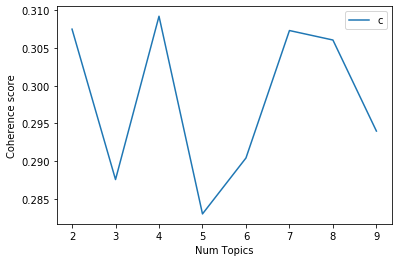

In [0]:
np.random.seed(10)
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_text, start=2, limit=10, step=1)
# Show graph
import matplotlib.pyplot as plt
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## Finding the optimal number of topics using coherence score and TFIDF 

In [0]:
#trains multiple LDA models and provides the models and their corresponding coherence scores.
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaMulticore(corpus=corpus_tfidf, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=processed_text, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

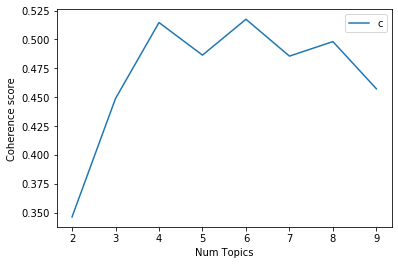

In [0]:
np.random.seed(20)
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus_tfidf, texts=processed_text, start=2, limit=10, step=1)
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"))
plt.show()


The above plot shows that coherence score increases with the number of topics, with a decline at 5 but decreases after the number of topics reached 6. 

## Visualize the topics with pyLDAvis

In [0]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.010423 -0.001841       1        1  32.792233
2     -0.000212  0.008275       2        1  18.802626
3     -0.001956 -0.005440       3        1  17.377064
4     -0.004904 -0.002277       4        1  14.521212
5     -0.000948  0.001520       5        1   8.791704
0     -0.002403 -0.000237       6        1   7.715174, topic_info=     Category      Freq           Term     Total  loglift  logprob
975   Default  6.000000         school  6.000000  30.0000  30.0000
244   Default  3.000000           raid  3.000000  29.0000  29.0000
1534  Default  3.000000          egypt  3.000000  28.0000  28.0000
3747  Default  3.000000  veselnitskaya  3.000000  27.0000  27.0000
3038  Default  3.000000     definitely  3.000000  26.0000  26.0000
...       ...       ...            ...       ...      ...      ...
473    Topic6  0.591299       evidence  4.557932   0.5197  -7.4910
2454   Topic6  0.580935          among  5.035905   0.4023  -7.5087
64     Topic6  0.576065    immigration  7.032884   0.0599  -7.5171
1302   Topic6  0.557109          human  4.996788   0.3682  -7.5506
494    Topic6  0.561152  investigation  6.412633   0.1259  -7.5433

[298 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3750      1  0.267309    african
3750      2  0.267309    african
3750      3  0.267309    african
3750      4  0.267309    african
1847      1  0.267298  afterward
...     ...       ...        ...
148       3  0.249251     worker
148       4  0.124626     worker
2708      1  0.268411    worried
2708      2  0.268411    worried
2708      3  0.268411    worried

[890 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 5, 6, 1])

## Fine tune LDA model 

In [0]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
# Define Search Param
search_params = {'n_components': [6], 'learning_decay': [.1, .5, .7, .9],'batch_size':[16,32,64,128,200], 'random_state': [100], 'max_iter':[100]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(TFIDF_matrix_2)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [0]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(TFIDF_matrix_2))

Best Model's Params:  {'batch_size': 16, 'learning_decay': 0.1, 'max_iter': 100, 'n_components': 6, 'random_state': 100}
Best Log Likelihood Score:  -1826.5561664864206
Model Perplexity:  57979.14540978976


In [0]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(TFIDF_matrix_2)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=titles)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if type(val) == int else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.style.applymap(color_green).applymap(make_bold)
df_document_topics

<61x2495 sparse matrix of type '<class 'numpy.float64'>'
	with 9451 stored elements in Compressed Sparse Row format>

In [0]:
# the distribution of documents across topics seem reasonable at least no all-absorbing cluster which pulls all the documents 
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,5,17
1,0,14
2,3,11
3,1,11
4,2,8
